<div style="margin: 0 auto 30px; height: 60px; border: 2px solid gray; border-radius: 6px;">
  <div style="float: left;"><img src="img/epfl.png" /></div>
  <div style="float: right; margin: 20px 30px 0; font-size: 10pt; font-weight: bold;"><a href="https://moodle.epfl.ch/course/view.php?id=18253">COM202 - Signal Processing</a></div>
</div>
<div style="clear: both; font-size: 30pt; font-weight: bold; color: #483D8B;">
    Lab 6: Continuos-Time Systems
</div>

In this notebook we will explore the basic ideas behind the classic models used to describe physical systems using continuous-time functions and operators. Once we have a theoretical model in place, we will look at how we can try to simulate continuous-time systems in software; the result will lead to a _discretization_ of the differential equations into difference equations describing well-known discrete-time systems.

In [1]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
from scipy import signal
plt.rcParams["figure.figsize"] = (14,4)

A little helper function used in later plots:

In [2]:
def plot_response(t, x, ylabel='', color='C0', sub=None, label=None, xlabel='time [$s$]'):
    ax = plt.subplot(*sub) if sub is not None else plt.subplot()
    plt.plot(t, x, color, lw=3, label=label)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.grid()

The following function simulates an analog first-order feedback system using SciPy's continuous-time toolbox. Don't worry if you don't understand the syntax or the details since we will only use this function as a "black box" in the rest of the notebook. 

In [3]:
def alp(input_signal, tau, t, t_0=0):
    # simulating a lowpass with transfer function H(s) = a / (s + a)
    #   input_signal: callable function describing the input (e.g. x = np.cos)
    #   tau: timing constant, a = 1/tau
    # computes the output over the time interval [t_0, t]
    t_d = np.linspace(t_0, t, max(1000, int((t-t_0)/0.01)))
    x = input_signal(t_d)
    t_v, v, _ = signal.lsim((1/tau, [1, 1/tau]), U=x, T=t_d)
    return t_d, v, x

# Continuous-time systems

In continuous time, signals are usually represented by functions of a real variable $t$ indicating time (in seconds). Since we are in the real world, a signal $x(t)$ will be expressed in some physical unit of measurement such as meters, volts, amperes, pascals, etc.

In continuous time, a very important concept is the **rate of change** of a signal, namely, how fast a signal increases or decreases over time; we know from basic calculus that the rate of change of a function is given by its first derivative $x'(t) = d x/ d t$. In many cases, the rate of change of a physical quantity is actually given a proper name:

 * if $x(t)$ indicates an object's position (in meters) at time $t$, $x'(t)$ represents its _speed_ (in $\mathrm{m/s}$)
 * if $x(t)$ measures the electrical charge (in coulomb), $x'(t)$ represents the _current_ (in amperes)
 * if $x(t)$ is the volume of liquid in a container (in $\mathrm{m^3}$) and the container has an opening, $x'(t)$ represents the _flow_ (in $\mathrm{m^3/s}$) entering or exiting the container.

## Memoryless systems

A memoryless system is one in which the output depends only on the instantaneous value of the input; what happened in the past has no influence on the present. Conversely, the output of a system with memory will be a function of all past values of the input.  

## Feedback systems

In a feedback system, the output is propagated back to the system in a way that affects the way the output changes over time. Obviously, a feedback system is a system with memory; to see this, simply "unroll" the causal chain of events: the current input affects the current output but, because of feedback, the current output will affect the future output, and therefore future output values will be dependent on past input values. 

# House plumbing to the rescue!

To illustrate the types and the main properties of continuous-time systems, here are three simple examples that you can find in your home and that you use every day.

<div style="float: right; margin: 10px;"><img src="img/tap.jpg" width="180"></div>

## A water tap is a memoryless system


A water tap (or faucet) is a valve that can regulate its output flow as a function of the position of a handle. We can model a tap as an elementary memoryless system:
 * the system's input $a(t)$ is the handle's position at time $t$; $a(t)$ is a dimensionless value between zero (tap closed) and one (tap fully open);
 * let $\rho$ denote the maximum water flow in $\mathrm{m}^3/\mathrm{s}$ provided by your house's plumbing system.
 
With this, the input-output relationship is simply

$$
    r(t) = \rho a(t) \qquad [\mathrm{m}^3/\mathrm{s}].
$$

## A bathtub has memory

<div style="float: right; margin: 10px;"><img src="img/bathtub.jpg" width="250"></div>

Imagine now you are filling your bathtub from the tap and call $v(t)$ the volume of water in the tub over time; assuming the tub is empty at $t=0$, we can write
$$
    v(t) = \int_0^t r(t)dt \qquad [\mathrm{m}^3];
$$
that is, the water in the tub is the accumulation of the flow from the tap over time. The past values of the flow rate influence the present value of collected water, giving us a simple example of a system with memory.

Note that if we differentiate the above equation we obtain

$$
    v'(t) = r(t) \qquad [\mathrm{m}^3/\mathrm{s}];
$$

this equivalent formulation shows that the _rate of change_ for the amount of water in the tub is equal to the instantaneous flow from the tap; this makes sense: if we open the tap more, the tub will fill faster, and vice-versa.

## A flush toilet is a feedback system
<div style="float: right; margin: 10px;"><img src="img/toilets.jpg" width="300"></div>

### How a toilet works

The flushing mechanism of a modern toilet is based on two components:
 * a water tank (basically, a bucket) that can quickly release a large amount of water in the bowl when the flush button is pressed
 * a mechanism to refill the tank automatically while preventing overflow.
 
A common design for the refill mechanism is a small water tap whose controlling lever is connected to a floating ball as shown in the figure below ([source](https://commons.wikimedia.org/w/index.php?curid=10404250)); as the volume of water in the tank increases, the lever is pushed up by the floater and progressively "closes" the tap, thereby reducing the refilling flow.

<center>
  <img src="img/ballcock.png" width="500"/>
  <div style="clear: both;"></div>
  <a href="https://commons.wikimedia.org/w/index.php?curid=10404250">source</a>
</center>

Let's assume that the "handle position" of the tap connected to the floater is linearly proportional to "how empty" the tank is; if we call $v(t)$ the water level during a fill cycle and if $V_M$ is the maximum fill level for the tank, we can write

$$
     a(t) = \frac{V_M - v(t)}{V_M}.  \tag{1}
$$

In particular note that:
  * when the tank is completely empty the tap is fully open: $v(t)=0 \Longrightarrow a(t) = 1$
  * when the tank is full the tap is shut off: $v(t)=V_M \Longrightarrow a(t)=0$

### How a toilet works, using differential equations

Again, with $v(t)$ the amount of water in the tank over time and $V_M$ be the maximum fill level, we can model the refilling process after flushing like so:

 * the flow rate from the tap is given by the tap's memoryless relation $r(t) = \rho a(t)$
 * $a(t)$ decreases linearly with the water level as shown in (1) above
 * the fill-up rate for the tank is equal to the flow exiting the tap, as for a bathtub: $v'(t) = r(t) = \rho a(t)$.

By putting it all together we obtain

$$
  v'(t) = \rho - (\rho/V_M)\,v(t) \tag{2}
$$

which is a linear, first-order differential equation describing the refilling process. 

We can use the substitution $g(t) = V_M-v(t)$ to obtain the homogeneous DE

$$
  g(t) + (V_M/\rho)g'(t) = 0 
$$

for which we know that the solution will have the form $g(t) = \alpha e^{\beta t}$ ([for more details, see for instance here](https://en.wikipedia.org/wiki/Linear_differential_equation#Homogeneous_equation_with_constant_coefficients)). 

The values for $\alpha$ and $\beta$ can be found from the so-called _initial conditions_: assume that the toilet is flushed at $t=0$ and that the flush instantaneously empties the tank; this translates to:
   * $v(0) = 0 \Rightarrow g(0) = V_M \Rightarrow \alpha = V_M$
   * $a(0) = 1$; since $g'(t) = \beta g(t)$ and $g'(t) = -v'(t) = -r(t) = -\rho a(t)$, we obtain $\beta = -\rho/V_M$
 
And so, in the end, the amount of water in the tank during a refilling cycle will be

$$
  v(t) = V_M(1 - e^{-t/\tau}), \quad \tau = V_M/\rho
$$

We can plug in some realistic values and plot the evolution of the amount of water in the tank, as well as the flow from the tap over time:

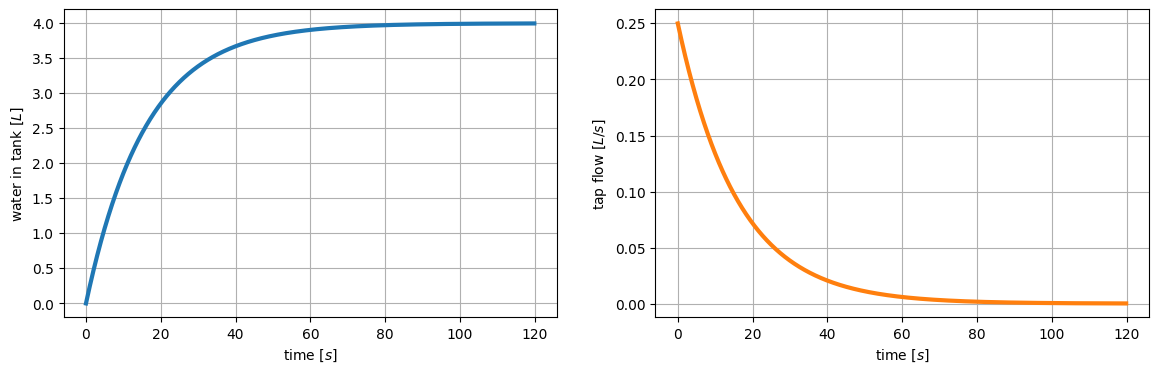

In [4]:
VM = 4       # less than 6 liters, as per European regulations!
rho = 15/60  # 15 l/m is good household tap flow

t = np.arange(0, 120, 0.1)           # two minutes
v = VM * (1 - np.exp(-rho/VM * t))   # tank level
a = rho * (VM - v) / VM              # tap flow

plot_response(t, v, 'water in tank [$L$]', 'C0', (1, 2, 1))
plot_response(t, a, 'tap flow [$L/s$]', 'C1', (1, 2, 2))


### Optional aside: stopping instant and time constant

In this idealized model for the refilling mechanism, the maximul water level $V_M$ is attained only asymptotically (that is, it would take an infinite amount of time to completely close the tap). In practice, of course, the tap's mechanical structure will stop the water flow before $a(t)$ reaches zero and the filling process will terminate in a finite amount of time (although the amount of water in the tank will be slightly lower than $V_M$ when the tap shuts close).

The value $\tau = V_M/\rho$ is called the **time constant** of the refilling system; from its expression (max volume divided by max flow rate) it's clear that its physical dimension is seconds and that it represents a lower bound on how long it takes to fill the tank given its volume and the maximum flow rate. For the exponential, asymptotic fill rate we just derived (as in many other cases such as the RC circuit described below), a useful rule of thumb is that the process is de facto complete _after five time constants;_ indeed

$$
    v(5\tau)  \approx 0.99\,  V_M
$$

In [5]:
# time constant
tau = VM / rho
print (f'time constant: {tau} s; fill-up time: {5 * tau} s')

time constant: 16.0 s; fill-up time: 80.0 s


### Optional aside: nonlinear toilets

The exponential fill-up curve is a consequence of the assumed linear relationship between water level and tap flow; but we could think of a different implementation with a tap that remains fully open until the water level is less that $V_M$ and then immediately shuts off when the maximum level is attained:

$$
    a(t) = \begin{cases}
        1 & \mbox{if $v(t) < V_M$} \\
        0 & \mbox{otherwise}
        \end{cases}
$$

Since this characteristics is discontinuous, we can no longer describe the system via a linear differential equation. In general it's very difficult to analyze the behavior of a nonlinear system but in this simple case we can still derive a closed-form expression for the fill-up curve: just like before, the fill rate will be equal to the flow rate and thus we can write 

$$
    v'(t) = r(t) = \rho a(t) = = \begin{cases}
        \rho & \mbox{if $v(t) < V_M$} \\
        0 & \mbox{otherwise}
        \end{cases}
$$

With the tank empty at $t=0$, we have

$$
    v(t) = \int_0^t v'(t)dt  = \begin{cases}
        \rho t & \mbox{if $t < V_M/\rho = \tau$} \\
        \rho \tau = V_M & \mbox{if $t \ge \tau$}
        \end{cases}
$$

Clearly, a nonlinear toilet will fill up much faster, namely, in  the span of just a single time constant:

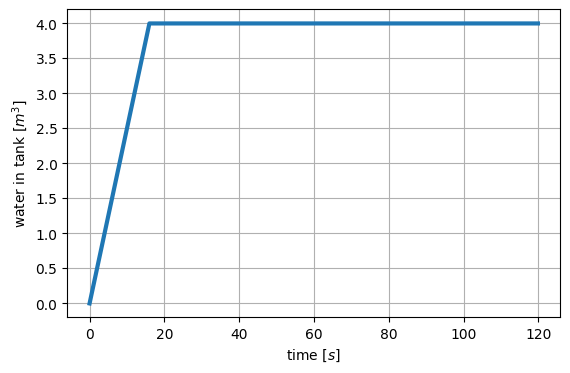

In [6]:
v = rho * np.minimum(t, tau)
plot_response(t, v, 'water in tank [$m^3$]', 'C0', (1,2,1))

# More feedback systems (that you can talk about over dinner)

The simple feedback loop in a toilet's water tank is obviously a rather tongue-in-cheek example, and yet its mathematical description mirrors exactly a myriad other natural phenomena; for example:
 * in 1701, Isaac Newton discovered that the rate of heat loss of a body is proportional to the difference in the temperatures between the body and its environment; if $h(t)$ represents the temperature of an object over time and $T_e$ is the ambient temperature, we can write
 $$
     h'(t) = K(T_e - h(t))
 $$
 which is exactly the same differential equation as in (2). In this case, $K$ is a constant that depends on the nature of the object and is called the heat transfer coefficient.
 * a radioactive isotope decays (i.e., transforms into a non-radioactive substance) at a rate that is directly proportional to its amount $q(t)$:
 $$
     q'(t) = \lambda \, q(t)
 $$
 where $\lambda$ is the so-called decay rate; the half life of a radioactive isotope is the time it takes for a given amount to reduce by one half, and this time is $t_{1/2} = (1/\lambda)\ln(2)$   
 
In the rest of this section, we will study in detail another first-order feedback system, namely the RC electronic circuit.

<div style="float: right; margin: 10px;"><img src="img/RC1.jpg" width="300"></div>

## The RC circuit

An RC circuit is an electronic circuit that uses only resistors and capacitors. The simplest type is as shown in the figure on the right, where the resistor and the capacitor are connected in series via a switch; it is usually assumed that the capacitor is charged to an initial voltage $V_0$ before the switch is closed, and we are interested in monitoring the evolution of voltage across the components over time. 

<div style="float: right; margin: 10px;"><img src="img/resistor.jpg" width="300"></div>

### The resistor
A resistor is a memoryless system described by the equation 
$$
    v(t) = R\, i(t).
$$
The current $i(t)$ flowing through a resistor is proportional to the instantaneous voltage $v(t)$ applied to its terminals; $R$ is the resistor's value, measured in ohms

<div style="float: right; margin: 10px;"><img src="img/capacitor.jpg" width="300"></div>

### The capacitor

A capacitor is a system with memory described by the formula 
$$
    v'(t) = (1/C)\,i(t)
$$
This means that the _rate of change_ for the voltage across the capacitor is proportional to the current flowing through it; $C$ is the capacitor's value, measured in farads. 

The memory effect is made apparent by integrating both sides:
$$
    v(t) = \frac{1}{C}\int_{-\infty}^t i(t)dt;
$$
since the current measures the flow of charges, the integral on the right-hand side represents the net amount of electrical charge inside the capacitor at time $t$. We can intuitively compare the behavior of a capacitor by analogy with the bathtub example:
 * think of the voltage as the water level accumulated in the tub
 * think of the current, which is the flow of charges, as the flow of water from the tap (although, in a capacitor, flow can go in both directions, in and out).

### Circuit analysis
The fundamental physical properties at play are the following:
 * when the switch is closed, the current $i(t)$ flowing through the resistor is the same as the current flowing through the capacitor
 * since the capacitor and the resistor are connected in parallel, the voltage across the resistor $v_R(t)$ is the same as the voltage across the capacitor $v_C(t)$

With this we have $v_C(t) = v_R(t) = Ri(t) = RCv_C'(t)$, yielding
$$
    v_C(t) - RC v'_c(t) = 0 
$$

This is the same differential equation as in the case of the refilling toilet tank, exept that now the capacitor is _discharging_ rather than filling up; from the initial condition $v_C(0) = V_0$ we obtain in this case

$$
    v_C(t) = V_0\,e^{-t/\tau} \qquad\mbox{time constant $\tau = RC$}
$$

Note that, since $R$ is expressed in ohms and $C$ in farads, the physical dimension of the product $RC$ is seconds, consistently with the concept of "time constant".  

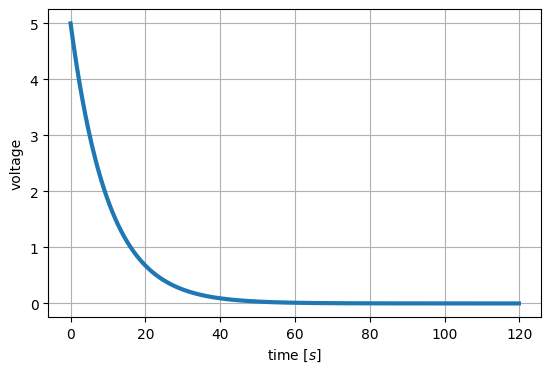

In [7]:
V0 = 5        # 5V
R = 10000     # 10 Kohm
C = 0.001     # 1000 micro farads

t = np.arange(0, 120, 0.1)    
v = V0 * np.exp(-t/(R * C))   

plot_response(t, v, 'voltage', 'C0', (1, 2, 1))

# Moving to discrete time

So far, we have only derived the so-called **natural response** of our simple feedback systems, that is, the way the system evolves from some initial conditions in the absence of external perturbations; in practice, however, we would like to model the response of a systems with respect to an arbitrary input signal.

For all the simple first-order feedback systems described so far, once we add a time-varying input and work out the math, the differential equation takes on the form

$$
    v(t) + \tau v'(t) = x(t)
$$

this is an inhomogeneous differential equation, usually solved by moving to the frequency domain with a Fourier transform, or the Laplace transform domain with the Laplace transform.


Instead of following that path, in the rest of this notebook we will show how a discretization of the continuous-time characteristic can bring us to the easier and more familiar territory of discrete-time filters.

## A discrete-time toilet

Let's consider once again the tank refilling process, but pretend that it happens in discrete, successive steps of duration $T$ seconds; at each step:
 * the water level $v[n]$ increases by a finite amount $d[n] = v[n] - v[n-1]$
 * $d[n]$ is the amount of water released by the tap in $T$ seconds: $d[n] = Tr[n]$ 
 * the flow rate depends on the water level at the start of the release interval and remains constant over $T$: $r[n] = \rho (V_M - v[n])/V_M$
 
Putting it all together:
$$
\begin{align*}
    v[n] - v[n-1] &= d[n]\\
      &= Tr[n] \\
      &= T\rho(V_M - v[n])/V_M
\end{align*}
$$
so that in the end
$$
    v[n] = (1-\lambda)V_M + \lambda v[n-1], \qquad \lambda = \frac{1}{1 + T/\tau},\quad  \tau = V_M/\rho ~~~[\mathrm{s}]
$$

We can write a simple Python function that computes the evolution of the water level as a function of the discretization interval $T$; by plotting the results against the ideal continuous-time response we can see that the approximation becomes increasingly more accurate as we reduce the "sampling" interval $T$:

In [8]:
def dt_t(T, t_end=120, VM=4, rho=15/60):
    lam = VM / (VM + T * rho)
    N = t_end // T + 1
    v = np.zeros(N)
    for n in range(1, N):
        v[n] = (1 - lam) * VM + lam * v[n-1]
    return np.arange(0, N) * T, v

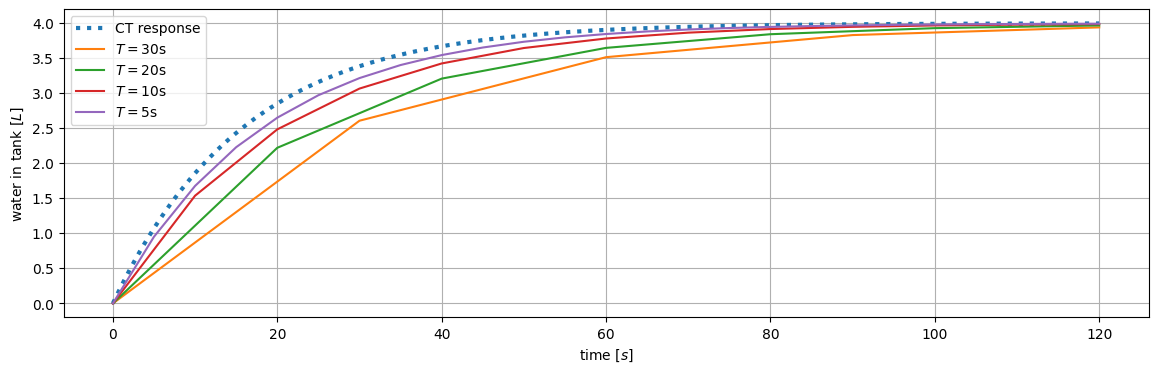

In [9]:
T_max = 120

VM, rho = 4, 15/60  # toilet parameters like before

t = np.arange(0, T_max, 0.01)
v = VM * (1 - np.exp(-t/(VM / rho)))   # tank level
plot_response(t, v, 'water in tank [$L$]', 'C0:', label='CT response')

for n, step in enumerate([30, 20, 10, 5]):
    plt.plot(*dt_t(step, T_max, VM, rho), f'C{n+1}', label=f"$T={step}$s")
plt.legend();

## From toilets to lowpasss filters

The discretization of the tank filling system is certainly interesting from the numerical point of view, since it provides us with an algorithm to compute the evolution of the water level that does not require the analytic solution of a differential equation. More importantly, however, the discretization shows us that the continuous-time natural response, once discretized, looks exactly like the output of a **leaky integrator** when the input is a step sequence:

$$
    y[n] = (1-\lambda)u[n] + \lambda y[n-1]
$$

From this, it is straightforward to extend the analysis to an arbitrary input, simply by replacing the step sequence $u[n]$ by a causal signal $x[n]$. 

As it turns out, each one of the first-order analog feedback systems we have seen can be considered a lowpass filter, and we will explore the key intuitions in the next section.

# Continuous-time lowpass filters

## A two-way water tank

<div style="float: right; margin: 0 30px;"><img src="img/actuator.jpg" width="400"></div>

Consider once again the tank filling system for a toilet but now imagine a hypothetical water tap that can either let water in (when the tap aperture $a(t)$ is positive) or pump water _out_ (when $a(t)$ is negative). This new system also has a crank, as in the picture on the right, that can be turned by the user in real time to change the target water level for the tank; in other words, the target fill-up level is no longer a fixed value $V_M$ but a time-varying value $x(t)$ that can be changed at any moment by the user. 

In this situation, the system will constantly try to attain the user-defined level $x(t)$ but, because of the finite amount of flow from the tap, changes in $x(t)$ will result in _slower_ changes in the tank's water level, as the filling process tries to "catch up" with the current target level. This, in essence, is the basic principle of a lowpass filter, which smooths out rapid changes in the input. 

### Numerical example
For a simple example, we can use the continuous-time system simulator defined at the beginning of this notebook. The function takes as inputs:
 * a _function_ to compute the value of the input at time $t$
 * the system's time constant $\tau$ (in seconds)
 * the stop time for the simulation (in seconds), which, by default, starts at $t=0$.

In the code below, we vary the input in a triangular, periodic pattern and plot the evolution of the water level in the tank against the input; we can make two fundamental observations:
 * the actual water level changes according to a smoother curve with respect to the input, as expected when lowpass filtering a signal with sharp corners
 * the peaks and valleys of the output _lag behind_ those of the input; this is a manifestation of the delay introduced by all filters

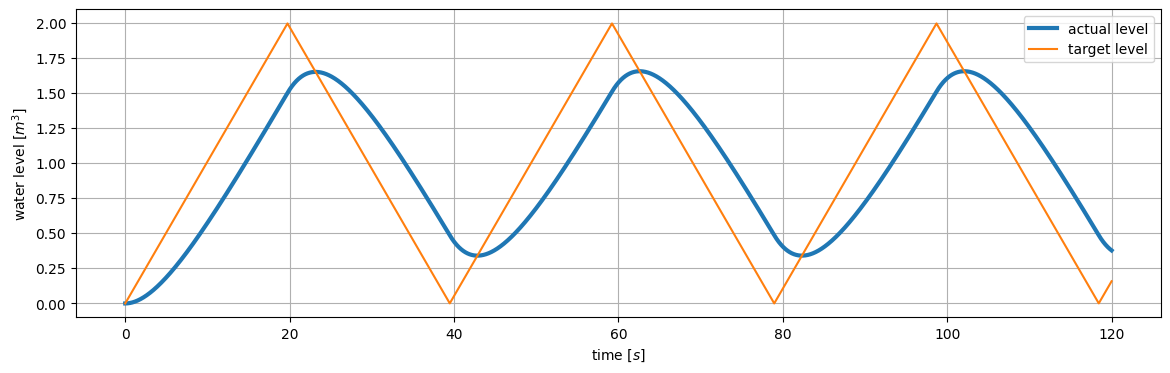

In [10]:
def sawtooth_input(t: np.ndarray) -> np.ndarray:
    # triangular pattern with period 20s and ranging from 0 to 2
    return signal.sawtooth(t/(2 * np.pi), 0.5) + 1

t, v, x = alp(sawtooth_input, 5, 120)
plot_response(t, v, 'water level [$m^3$]', 'C0', label='actual level')
plt.plot(t, x, 'C1', label='target level')
plt.legend();

### Exercise: tracking a square-wave input

Using the same approach as for the triangular input above, plot the response of the filling tank when the input is a symmetric square wave with period 40 seconds and ranging from zero to 2.

In [11]:
def square_input(t: np.ndarray) -> np.ndarray:
    # square wave with period 20s and ranging from 0 to 2
    pass

# plotting code here (same as in the previous cell)

#t, v, x = alp(...)
#...

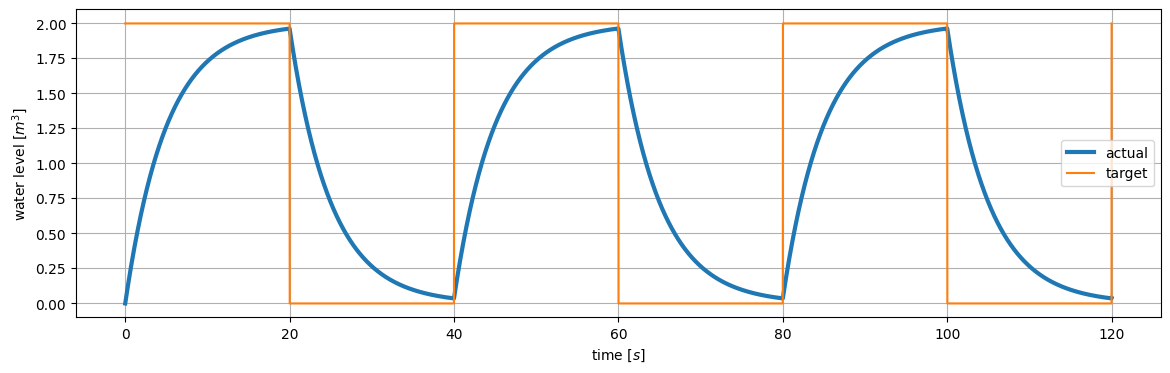

In [12]:
# SOLUTION:

def square_input(t):
    # square wave with period 20s and ranging from 0 to 2
    return 2 - np.mod(np.floor(t / 20), 2) * 2

t, v, x = alp(square_input, 5, 120)
plot_response(t, v, 'water level [$m^3$]', 'C0', label='actual')
plt.plot(t, x, 'C1', label='target')
plt.legend();

<div style="float: right; margin: 10px;"><img src="img/rc.png" width="300"></div>

## The discretized RC lowpass

In the RC circuit here on the right, we would like to know the response $v(t) = v_{\mathrm{out}}(t)$ as a function of the arbitrary input signal $x(t) = v_{\mathrm{in}}(t)$. We will use a discretization approach to show that the circuit implements a lowpass filter.

### Discretization via finite differences

An alternative way to discretize a differential equation uses the first-difference approximation to the derivative: $v'(t) \approx \frac{v(t) - v(t - T)}{T}$. 

We can apply this to the equation describing an RC circuit driven by an external input; if we let $v[n] = v(nT)$, the expression $v(t) + RCv'(t) = x(t)$  becomes $v[n] + (RC/T)(v[n] - v[n-1]) = x[n]$ and, after a few steps we finally obtain

$$
  v[n] = (1-\lambda) x[n] + \lambda v[n-1] \qquad \lambda=\frac{1}{1 + T/\tau}, \quad \tau = RC~~~[\mathrm{s}]
$$

Once again, we obtain the constant-coefficient difference equation that describes a leaky integrator, which we know to be a lowpass filter.

### Exercise: write your own discretized RC filter

Implement a discrete-time RC filter via a leaky integrator where you can specify the values of the time constant $\tau$ and of the discretization step $T$.

The last cell in this section will apply the filter to the inputs defined previously; you will be able to check visually that, as $T$ becomes smaller, the discrete-time simulations approach the continuous-time response of the analog filter

In [13]:
def rcd(input_signal, tau, T, t_end) -> tuple[np.ndarray, np.ndarray]:
    #   input_signal: callable function describing the input
    #   tau: timing constant
    #   T: discretization interval (seconds)
    #   t_end: output will be computed over the time interval [0, t_end]
    # returns the discretization instants and the corresponding output
    t = ...
    y = ...
    return t, y    

In [14]:
# SOLUTION: 

def rcd(input_signal, tau, T, t_end):
    lam = 1 / (1 + T/tau)
    t = np.linspace(0, t_end, int(t_end / T))
    y = np.zeros(len(t))
    for n, x in enumerate(input_signal(t)):
        y[n] = (1 - lam) * x + lam * y[n-1]
    return t, y    

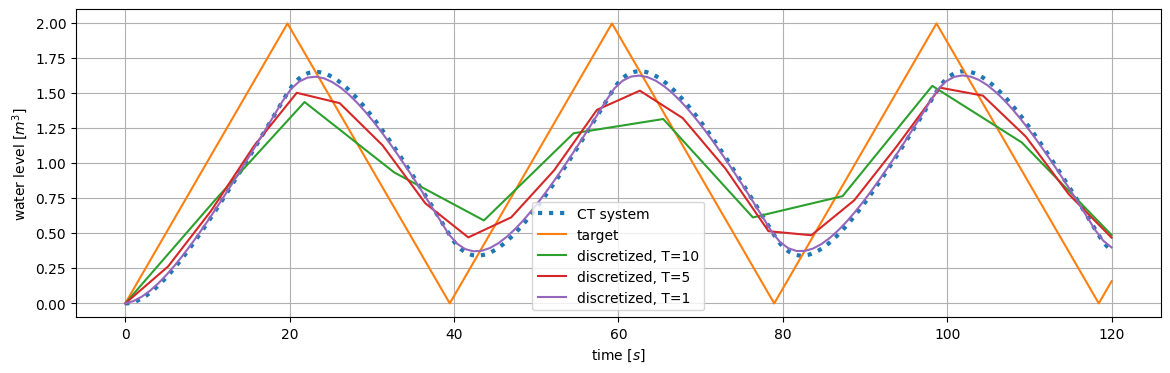

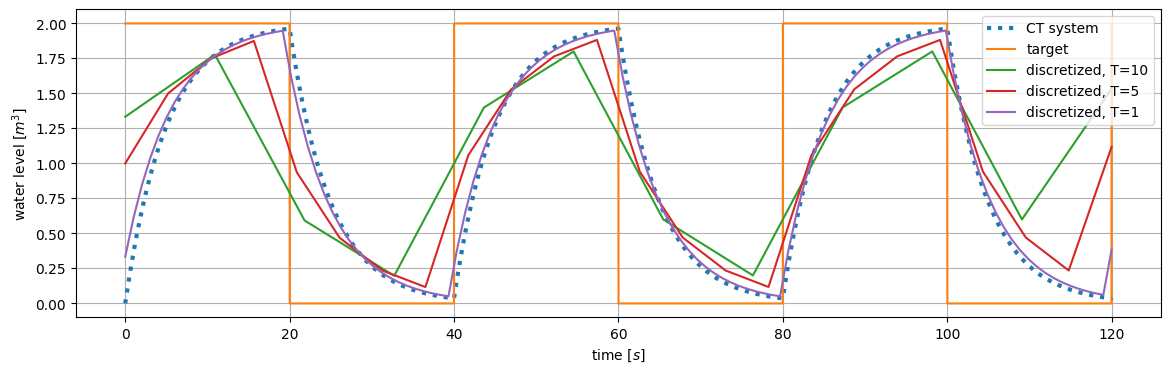

In [15]:
for input_signal in [sawtooth_input, square_input]:
    plt.figure()

    # analog simulation
    t, v, x = alp(input_signal, 5, 120)
    plot_response(t, v, 'water level [$m^3$]', 'C0:', label='CT system')
    plt.plot(t, x, 'C1', label='target')

    # discretized models
    for c, T in enumerate([10, 5, 1]):
        plt.plot(*rcd(input_signal, 5, T, 120), f'C{c+2}', label=f'discretized, T={T}')
    plt.legend();